# Crop recommendation using Ensemble Learning

## Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import preprocessing as pre
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from pickle import dump

## Data Preparation

**Importing the data**

In [2]:
data = pd.read_csv(r'crop.csv')
data.reset_index(drop = True, inplace = True)
data.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


**Shape of the data**

In [3]:
data.shape

(2200, 8)

**Checking missing values**

In [4]:
data.isnull().sum()

N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64

**Data types**

In [5]:
data.dtypes

N                int64
P                int64
K                int64
temperature    float64
humidity       float64
ph             float64
rainfall       float64
label           object
dtype: object

**Checking the unique targets in the dataframe**

In [6]:
data['label'].nunique()

22

In [7]:
data['label'].value_counts()

rice           100
maize          100
jute           100
cotton         100
coconut        100
papaya         100
orange         100
apple          100
muskmelon      100
watermelon     100
grapes         100
mango          100
banana         100
pomegranate    100
lentil         100
blackgram      100
mungbean       100
mothbeans      100
pigeonpeas     100
kidneybeans    100
chickpea       100
coffee         100
Name: label, dtype: int64

**Descriptive statistics**

In [8]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
N,2200.0,50.551818,36.917334,0.000000,21.000000,37.000000,84.250000,140.000000
P,2200.0,53.362727,32.985883,5.000000,28.000000,51.000000,68.000000,145.000000
K,2200.0,48.149091,50.647931,5.000000,20.000000,32.000000,49.000000,205.000000
temperature,2200.0,25.616244,5.063749,8.825675,22.769375,25.598693,28.561654,43.675493
humidity,2200.0,71.481779,22.263812,14.258040,60.261953,80.473146,89.948771,99.981876
ph,2200.0,6.469480,0.773938,3.504752,5.971693,6.425045,6.923643,9.935091
rainfall,2200.0,103.463655,54.958389,20.211267,64.551686,94.867624,124.267508,298.560117


The descriptive statistics shows that the minimum value of column N is 0 which is not possible as Nitrogen is essential for the growth of crops. 0 therefore, will be considered as missing values.

**Handling missing values**

In [9]:
# Indices of rows where N is 0.
ind = list(data[data['N'] == 0].index)
len(ind)

27

In [10]:
# Dropping rows with missing values.
data.drop(ind, inplace = True)
data.reset_index(drop = True, inplace = True)
data.shape

(2173, 8)

The rows with missing values were dropped from the data as the number of missing values were very less compared to the total rows in the data.

**Features correlation**

<AxesSubplot:>

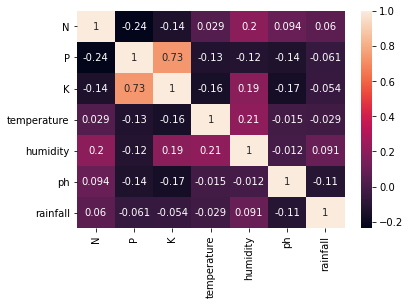

In [11]:
# Correlation heatmap.
sns.heatmap(data.corr(), annot = True)

From the correlation heatmap, we can see that there is a very high correlation between the raios of Phosphorus (P) and Potassium (K). Therefore, dropping one of the columns is necessary to avoid multicollinearity.

**Feature and target data**

In [12]:
target = data['label']
features_name = data.drop(columns = ['label', 'P'])# Dropping Phosphorus and the target from the data.
features = features_name.values

In [13]:
features

array([[ 90.        ,  43.        ,  20.87974371,  82.00274423,
          6.50298529, 202.9355362 ],
       [ 85.        ,  41.        ,  21.77046169,  80.31964408,
          7.03809636, 226.6555374 ],
       [ 60.        ,  44.        ,  23.00445915,  82.3207629 ,
          7.84020714, 263.9642476 ],
       ...,
       [118.        ,  30.        ,  24.13179691,  67.22512329,
          6.36260785, 173.3228386 ],
       [117.        ,  34.        ,  26.2724184 ,  52.12739421,
          6.75879255, 127.1752928 ],
       [104.        ,  30.        ,  23.60301571,  60.39647474,
          6.77983261, 140.9370415 ]])

In [14]:
target

0         rice
1         rice
2         rice
3         rice
4         rice
         ...  
2168    coffee
2169    coffee
2170    coffee
2171    coffee
2172    coffee
Name: label, Length: 2173, dtype: object

**Encoding the target**

In [15]:
LE = pre.LabelEncoder()
target = LE.fit_transform(target)
target

array([20, 20, 20, ...,  5,  5,  5])

In [16]:
np.unique(target)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21])

In [17]:
# Saving the encoder for inverse transforming the predictions.
dump(LE, open('label.pkl', 'wb'))

**Splitting the data into training and testing datasets**

In [18]:
# Splitting into 80% training dataset and 20% testing dataset.
X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size = 0.2)

In [19]:
print('Train data shape:', (X_train.shape))
print('Test data shape:', (X_test.shape))

Train data shape: (1738, 6)
Test data shape: (435, 6)


In [20]:
np.unique(Y_train, return_counts = True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]),
 array([80, 83, 79, 78, 81, 84, 77, 77, 80, 79, 76, 79, 80, 72, 83, 79, 78,
        80, 78, 72, 83, 80], dtype=int64))

**Scaling the features**

In [21]:
# Robust sacler is used as there may be some outliers in the data.
scaler = pre.RobustScaler()
# Train data
#train_scaled = scaler.fit_transform(X_train)
scaler.fit(X_train)
train_scaled = scaler.transform(X_train)
train_scaled

array([[ 0.17460317,  0.51724138, -0.05413738,  0.42646775,  0.39982137,
         1.23404254],
       [-0.49206349,  5.89655172, -2.22126693,  0.03842452, -0.31508101,
        -0.45644317],
       [-0.14285714, -0.31034483,  0.46898938, -0.63315565,  1.03959426,
        -0.33916864],
       ...,
       [ 0.71428571,  0.75862069,  0.63310126,  0.3239202 ,  0.12147839,
        -1.16851342],
       [ 1.06349206,  0.48275862,  0.59863516, -0.01281959, -0.15351032,
        -0.08459962],
       [-0.0952381 ,  1.72413793, -0.83258981, -2.13167347,  1.24584947,
        -0.26125153]])

In [22]:
# Test data
test_scaled = scaler.transform(X_test)
test_scaled

array([[ 0.80952381,  0.51724138,  0.03488232,  0.21025454,  0.25015349,
        -0.85875794],
       [ 1.26984127,  0.06896552,  0.10504958, -0.96531109,  0.35274552,
         0.49224074],
       [-0.41269841, -0.51724138,  0.11675623, -0.8474319 ,  1.68888112,
        -0.95395216],
       ...,
       [ 0.82539683,  0.51724138,  0.41888699, -0.09187128, -0.84536085,
         0.21524778],
       [ 0.96825397, -0.17241379, -0.1632137 , -0.99375721,  0.86206891,
         1.599128  ],
       [-0.31746032, -0.4137931 ,  0.48962903, -1.20100242, -2.79810149,
        -0.4659038 ]])

## Data Modeling

The classification techniques used for classifcation of the crops are: <br>
**1.** *k-nearest neigbors.* <br>
**2.** *Decision Tree.* <br>
**3.** *Random Forest Classifier.* <br>
**4.** *Gaussian Naive Bayes.* <br>
These algorithms will then be used for the **ensemble learning model**.

**Classifiers**

In [23]:
# Instantiating the classifiers.
knn = KNeighborsClassifier()
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier()
gnb = GaussianNB()

**Voting classifier**

In [24]:
# Ensemble learning model.
ensemble = VotingClassifier(
                            estimators = [('knn', knn), ('dtc', dtc), ('rfc', rfc), ('gnb', gnb)],
                            voting = 'hard')

In [25]:
# Training the model.
ensemble.fit(X_train, Y_train)

VotingClassifier(estimators=[('knn', KNeighborsClassifier()),
                             ('dtc', DecisionTreeClassifier()),
                             ('rfc', RandomForestClassifier()),
                             ('gnb', GaussianNB())])

In [26]:
# Predicting on the test set.
Y_pred = ensemble.predict(X_test)

**Model performance**

In [27]:
print("The accuracy of the model is: %.4f" % metrics.accuracy_score(Y_test, Y_pred))

The accuracy of the model is: 0.9908


**Saving the model**

In [28]:
dump(ensemble, open('ensemble.pkl', 'wb'))

**Comparing the actual and predicted values**

In [29]:
predicted_df = pd.DataFrame(data = X_test, columns = features_name.columns)
predicted_df['Actual'] = LE.inverse_transform(Y_test)
predicted_df['Predicted'] = LE.inverse_transform(Y_pred)

In [30]:
predicted_df.sample(10)

,N,K,temperature,humidity,ph,rainfall,Actual,Predicted
281,36.0,13.0,17.340837,93.048972,7.191727,112.719428,orange,orange
241,44.0,18.0,28.036441,65.066017,6.814411,72.495077,blackgram,blackgram
256,39.0,20.0,29.349971,61.253539,8.055909,40.828407,mothbeans,mothbeans
255,8.0,33.0,28.278043,93.647613,6.095261,171.945796,coconut,coconut
140,86.0,45.0,27.812515,82.692854,5.807664,99.209615,banana,banana
384,23.0,18.0,26.490833,47.365348,5.414493,36.993628,mothbeans,mothbeans
373,119.0,51.0,26.473302,80.922544,6.283818,53.657426,watermelon,watermelon
32,36.0,21.0,34.538239,39.044689,5.617008,168.594832,pigeonpeas,pigeonpeas
312,8.0,38.0,19.301063,87.177517,7.005411,105.476659,pomegranate,pomegranate
199,54.0,52.0,36.567697,93.795034,6.867554,104.421860,papaya,papaya
